In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
import cv2
from tensorflow.python.ops.resource_variable_ops import ResourceVariable
from tensorflow.python.framework.ops import EagerTensor
from sklearn.model_selection import train_test_split
from PIL import Image

In [3]:

# Define the path to your dataset folder
dataset_folder = 'dataset'

# Specify the batch size and image size
batch_size = 32
image_size = (120, 120)

# Create a training dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_folder,
    validation_split=0.2,  # You can adjust the validation split
    subset="training",
    seed=1337,  # Set a seed for reproducibility
    image_size=image_size,
    batch_size = None
)

# Create a validation dataset
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_folder,
    validation_split=0.2,  # You can adjust the validation split
    subset="validation",
    seed=1337,  # Set a seed for reproducibility
    image_size=image_size,
    batch_size = None
)

# Extract features (x) and labels (y) from training dataset
train_x = train_dataset.map(lambda x, y: x)
train_y = train_dataset.map(lambda x, y: y)

# Extract features (x) and labels (y) from validation dataset
test_x = validation_dataset.map(lambda x, y: x)
test_y = validation_dataset.map(lambda x, y: y)

# Print class names (folders representing different weather conditions)
class_names = train_dataset.class_names
print("Class names:", class_names)



Found 6862 files belonging to 11 classes.
Using 5490 files for training.
Found 6862 files belonging to 11 classes.
Using 1372 files for validation.
Class names: ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']


In [4]:
type(train_x)

tensorflow.python.data.ops.map_op._MapDataset

In [5]:
print(train_x.element_spec)



TensorSpec(shape=(120, 120, 3), dtype=tf.float32, name=None)


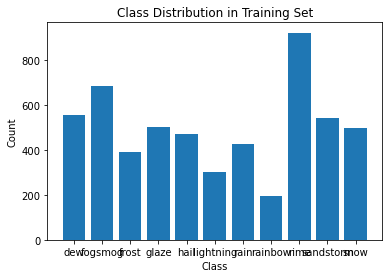

In [30]:
# Calculate class counts for the training set
class_counts = np.zeros(len(class_names), dtype=int)
for _, labels_batch in train_dataset:
    labels_batch = labels_batch.numpy().flatten()
    class_counts += np.bincount(labels_batch, minlength=len(class_names))

# Plot the distribution of classes in the training set
plt.bar(class_names, class_counts)
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

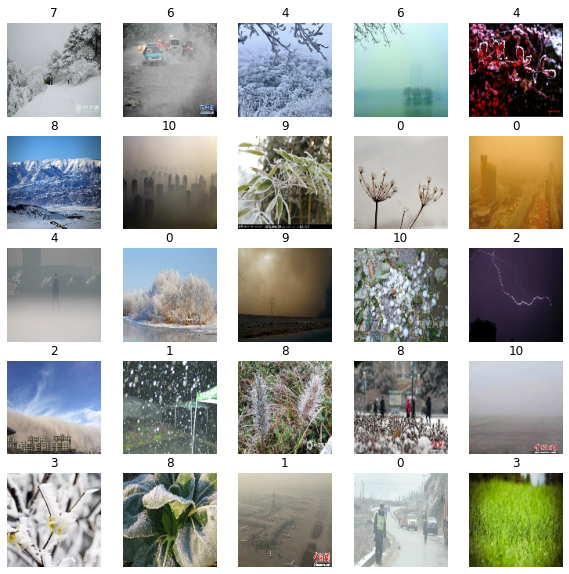

In [50]:
images_iter = iter(train_x)
labels_iter = iter(train_y)
plt.figure(figsize=(10, 10))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(next(images_iter).numpy().astype("uint8"))
    plt.title(next(labels_iter).numpy().astype("uint8"))
    plt.axis("off")

In [51]:
def normalize(image):
    """
    Transform an image into a tensor of shape (120 * 120 * 3, )
    and normalize its components.
    
    Arguments
    image - Tensor.
    
    Returns: 
    result -- Transformed tensor 
    """
    
    image = tf.reshape(image, shape=( image_size[0], image_size[1], 3))/250.0

# Flatten the reshaped tensor
    image = tf.reshape(image, shape=(-1,))


    return image

In [52]:
new_train = train_x.map(normalize)
new_test = test_x.map(normalize)

In [53]:
new_train.element_spec

TensorSpec(shape=(43200,), dtype=tf.float32, name=None)

In [54]:
def one_hot_matrix(label, C=11):
    """
    Computes the one hot encoding for a single label
    
    Arguments:
        label --  (int) Categorical labels
        C --  (int) Number of different classes that label can take
    
    Returns:
         one_hot -- tf.Tensor A single-column matrix with the one hot encoding.
    """
    #one hot encoding
    one_hot = tf.reshape(tf.one_hot(label, C, axis = 0), [C,])
    return one_hot

In [55]:
# new_y_test = tf.map_fn(one_hot_matrix, tensor_data)
# new_y_train = y_train.map(one_hot_matrix)
new_y_test = test_y.map(one_hot_matrix)
new_y_train = train_y.map(one_hot_matrix)

In [56]:
for label in new_y_test.take(10):
    print(label)
print(new_y_train.element_spec)

tf.Tensor([1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(11,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.], shape=(11,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.], shape=(11,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(11,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(11,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(11,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.], shape=(11,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.], shape=(11,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(11,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.], shape=(11,), dtype=float32)
TensorSpec(shape=(11,), dtype=tf.float32, name=None)


In [57]:
# GRADED FUNCTION: initialize_parameters

def initialize_parameters():
    """
    Initializes parameters to build a neural network with TensorFlow. The shapes are:
                        W1 : [44, 43200]
                        b1 : [44, 1]
                        W2 : [22, 44]
                        b2 : [22, 1]
                        W3 : [11, 22]
                        b3 : [11, 1]
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
                                
    initializer = tf.keras.initializers.GlorotNormal(seed=1)   


    W1 = tf.Variable(initializer(shape=(44, 43200)))
    b1 = tf.Variable(initializer(shape=(44, 1)))
    W2 = tf.Variable(initializer(shape=(22, 44))) 
    b2 = tf.Variable(initializer(shape=(22, 1)))
    W3 = tf.Variable(initializer(shape=(11, 22)))
    b3 = tf.Variable(initializer(shape=(11, 1)))



    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters





In [58]:
parameters = initialize_parameters()
print(type(parameters['W1']))
print(type(new_train))
print(tf.shape(parameters['W1']))

<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
<class 'tensorflow.python.data.ops.map_op._MapDataset'>
tf.Tensor([   44 43200], shape=(2,), dtype=int32)


In [59]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    # Numpy Equivalents:
    # Z1 = np.dot(W1, X) + b1
    # A1 = relu(Z1)
    # Z2 = np.dot(W2, A1) + b2
    # A2 = relu(Z2)
    # Z3 = np.dot(W3, A2) + b3
    Z1 = tf.math.add(tf.linalg.matmul(W1,X),b1)
    A1 = tf.keras.activations.relu(Z1)
    Z2 = tf.math.add(tf.linalg.matmul(W2,A1),b2)
    A2 = tf.keras.activations.relu(Z2)
    Z3 = tf.math.add(tf.linalg.matmul(W3,A2),b3)
    
    return Z3

In [60]:
# GRADED FUNCTION: compute_total_loss

def compute_total_loss(logits, labels):
    """
    Computes the total loss
    
    Arguments:
    logits -- output of forward propagation (output of the last LINEAR unit), of shape (6, num_examples)
    labels -- "true" labels vector, same shape as Z3
    
    Returns:
    total_loss - Tensor of the total loss value
    """
    
  
    #total loss
    total_loss = tf.reduce_sum(tf.keras.losses.categorical_crossentropy(labels, logits, from_logits=True))
    
    
    # YOUR CODE ENDS HERE
    return total_loss


In [61]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 10 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    costs = []                                        # To keep track of the cost
    train_acc = []
    test_acc = []
    
    # Initialize your parameters
    #(1 line)
    parameters = initialize_parameters()

    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']

    optimizer = tf.keras.optimizers.Adam(learning_rate)
    
    # The CategoricalAccuracy will track the accuracy for this multiclass problem
    test_accuracy = tf.keras.metrics.CategoricalAccuracy()
    train_accuracy = tf.keras.metrics.CategoricalAccuracy()
    
    dataset = tf.data.Dataset.zip((X_train, Y_train))
    test_dataset = tf.data.Dataset.zip((X_test, Y_test))
    
    # We can get the number of elements of a dataset using the cardinality method
    m = dataset.cardinality().numpy()
    
    minibatches = dataset.batch(minibatch_size).prefetch(8)
    test_minibatches = test_dataset.batch(minibatch_size).prefetch(8)
#     X_train = X_train.batch(minibatch_size, drop_remainder=True).prefetch(8)# <<< extra step    
#     Y_train = Y_train.batch(minibatch_size, drop_remainder=True).prefetch(8) # loads memory faster 

    # Do the training loop
    for epoch in range(num_epochs):

        epoch_total_loss = 0.
        
        #We need to reset object to start measuring from 0 the accuracy each epoch
        train_accuracy.reset_states()
        
        for (minibatch_X, minibatch_Y) in minibatches:
   
            
            with tf.GradientTape() as tape:
                # 1. predict
                Z3 = forward_propagation(tf.transpose(minibatch_X), parameters)

                # 2. loss
                minibatch_total_loss = compute_total_loss(Z3, tf.transpose(minibatch_Y))

            # We accumulate the accuracy of all the batches
            train_accuracy.update_state(minibatch_Y, tf.transpose(Z3))
            
            trainable_variables = [W1, b1, W2, b2, W3, b3]
            grads = tape.gradient(minibatch_total_loss, trainable_variables)
            optimizer.apply_gradients(zip(grads, trainable_variables))
            epoch_total_loss += minibatch_total_loss
        
        # We divide the epoch total loss over the number of samples
        epoch_total_loss /= m

        # Print the cost every 10 epochs
        if print_cost == True and epoch % 10 == 0:
            print ("Cost after epoch %i: %f" % (epoch, epoch_total_loss))
            print("Train accuracy:", train_accuracy.result())
            
            # We evaluate the test set every 10 epochs to avoid computational overhead
            for (minibatch_X, minibatch_Y) in test_minibatches:
                Z3 = forward_propagation(tf.transpose(minibatch_X), parameters)
                test_accuracy.update_state(minibatch_Y, tf.transpose(Z3))
            print("Test_accuracy:", test_accuracy.result())

            costs.append(epoch_total_loss)
            train_acc.append(train_accuracy.result())
            test_acc.append(test_accuracy.result())
            test_accuracy.reset_states()


    return parameters, costs, train_acc, test_acc

In [62]:
parameters, costs, train_acc, test_acc = model(new_train, new_y_train, new_test, new_y_test, num_epochs=100)

Cost after epoch 0: 4990.887207
Train accuracy: tf.Tensor(0.09763206, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.11005831, shape=(), dtype=float32)
Cost after epoch 10: 32502410.000000
Train accuracy: tf.Tensor(0.16794172, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.1734694, shape=(), dtype=float32)
Cost after epoch 20: 183102208.000000
Train accuracy: tf.Tensor(0.16794172, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.1734694, shape=(), dtype=float32)
Cost after epoch 30: 495652768.000000
Train accuracy: tf.Tensor(0.16794172, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.1734694, shape=(), dtype=float32)
Cost after epoch 40: 993165376.000000
Train accuracy: tf.Tensor(0.16794172, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.1734694, shape=(), dtype=float32)
Cost after epoch 50: 1683434880.000000
Train accuracy: tf.Tensor(0.16794172, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.1734694, shape=(), dtype=float32)
Cost after epoch 60: 2617693440.0

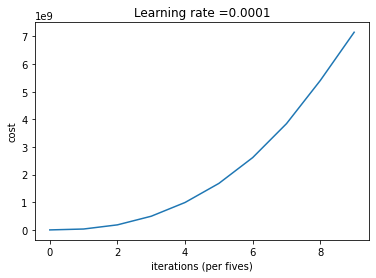

In [63]:
# Plot the cost
plt.plot(np.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('iterations (per fives)')
plt.title("Learning rate =" + str(0.0001))
plt.show()


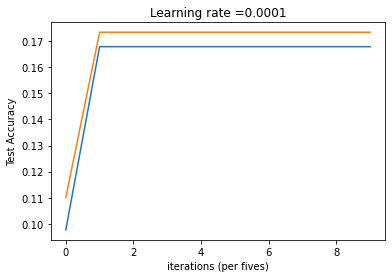

In [64]:
# Plot the train accuracy
plt.plot(np.squeeze(train_acc))
plt.ylabel('Train Accuracy')
plt.xlabel('iterations (per fives)')
plt.title("Learning rate =" + str(0.0001))
# Plot the test accuracy
plt.plot(np.squeeze(test_acc))
plt.ylabel('Test Accuracy')
plt.xlabel('iterations (per fives)')
plt.title("Learning rate =" + str(0.0001))
plt.show()


In [90]:
# parameterss =  [key for key in parameters]
# values = 
# with open('training_results.json', 'w') as json_file:
#     json.dump(parameterss, json_file)
variables_numpy = {key: value.numpy().tolist() for key, value in parameters.items()}

# Save NumPy arrays to a JSON file
with open('saved_variables.json', 'w') as file:
    json.dump(variables_numpy, file)

In [91]:
def load_and_preprocess_image(image_path, image_size):
    """
    Load and preprocess an image from the specified file path.

    Arguments:
    image_path -- file path to the image
    image_size -- tuple specifying the desired size of the image

    Returns:
    processed_image -- preprocessed image as a numpy array
    """

    # Load the image
    image = np.array(Image.open(image_path).resize(image_size))
    plt.imshow(image)
    plt.show()

    # Normalize the pixel values
    processed_image = image / 255.0

    # Reshape the image to match the input size of the model
    processed_image = processed_image.reshape((1, 120*120*3)).T

    return processed_image

def predict(image_path):
    """
    Predicts the label for an input image using the trained parameters.

    Arguments:
    parameters -- a dictionary containing the parameters (weights and biases) of the model.
    image_path -- file path to the input image
    image_size -- tuple specifying the desired size of the image

    Returns:
    prediction -- a numpy array containing the predicted label probabilities
    """
    image_size = (120,120) 
    with open('saved_variables.json', 'r') as file:
        loaded_variables = json.load(file)

    # Convert NumPy arrays to TensorFlow variables
    parameters = {key: tf.Variable(np.array(value, dtype=np.float32)) for key, value in loaded_variables.items()}
    # Load and preprocess the image
    processed_image = load_and_preprocess_image(image_path, image_size)

    # Forward propagation using the predict function
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']

    # Forward propagation
    Z1 = tf.matmul(W1, processed_image) + b1
    A1 = tf.nn.relu(Z1)
    Z2 = tf.matmul(W2, A1) + b2
    A2 = tf.nn.relu(Z2)
    Z3 = tf.matmul(W3, A2) + b3

    # Apply softmax to get probabilities
    predictions = tf.nn.softmax(tf.transpose(Z3))
    predicted_labels = tf.argmax(predictions, axis=1).numpy()
    print("Predicted Weather:", class_names[int(predicted_labels)])



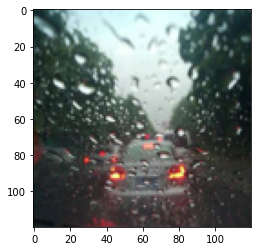

Predicted Weather: rime


In [94]:
# Assuming X_new is your new data (input features)
X = 'imagee.jpg'
predictions = predict(X)



In [95]:
print(class_names)

['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']
